In [21]:
# Built-in modules
import math

# Imports from Qiskit
from qiskit import QuantumCircuit
from qiskit.circuit.library import GroverOperator, MCMT, ZGate
from qiskit.visualization import plot_distribution

# Imports from Qiskit Runtime
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Batch

# To run on hardware, select the backend with the fewest number of jobs in the queue
service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.least_busy(operational=True, simulator=False)
backend.name

def grover_oracle(marked_states):
    """Build a Grover oracle for multiple marked states

    Here we assume all input marked states have the same number of bits

    Parameters:
        marked_states (str or list): Marked states of oracle

    Returns:
        QuantumCircuit: Quantum circuit representing Grover oracle
    """
    if not isinstance(marked_states, list):
        marked_states = [marked_states]
    # Compute the number of qubits in circuit
    num_qubits = len(marked_states[0])

    qc = QuantumCircuit(num_qubits)
    # Mark each target state in the input list
    for target in marked_states:
        # Flip target bit-string to match Qiskit bit-ordering
        rev_target = target[::-1]
        # Find the indices of all the '0' elements in bit-string
        zero_inds = [ind for ind in range(num_qubits) if rev_target.startswith("0", ind)]
        # Add a multi-controlled Z-gate with pre- and post-applied X-gates (open-controls)
        # where the target bit-string has a '0' entry
        qc.x(zero_inds)
        qc.compose(MCMT(ZGate(), num_qubits - 1, 1), inplace=True)
        qc.x(zero_inds)
    return qc


marked_states = ["011", "100"]

oracle = grover_oracle(marked_states)
oracle.draw(output="mpl", style="iqp")

grover_op = GroverOperator(oracle)
grover_op.decompose().draw(output="mpl", style="iqp")

optimal_num_iterations = math.floor(
    math.pi / (4 * math.asin(math.sqrt(len(marked_states) / 2**grover_op.num_qubits)))
)

qc = QuantumCircuit(grover_op.num_qubits)
# Create even superposition of all basis states
qc.h(range(grover_op.num_qubits))
# Apply Grover operator the optimal number of times
qc.compose(grover_op.power(optimal_num_iterations), inplace=True)
# Measure all qubits
qc.measure_all()
qc.draw(output="mpl", style="iqp")

# To run on local simulator:
#   1. Use the Sampler from qiskit.primitives instead
#   2. Remove the Batch context manager below

with Batch(backend=backend) as batch:
    sampler = Sampler()
    dist = sampler.run(qc, shots=10000).result().quasi_dists[0]
    
plot_distribution(dist.binary_probabilities())

/tmp/ipykernel_82/2399881893.py:28: DeprecationWarning: Circuits that do not match the target hardware definition will no longer be supported after March 1, 2024. See the transpilation documentation (https://docs.quantum.ibm.com/transpile) for instructions to transform circuits and the primitive examples (https://docs.quantum.ibm.com/run/primitives-examples) to see this coupled with operator transformations.
  dist = sampler.run(qc, shots=10000).result().quasi_dists[0]
base_primitive._run_primitive:INFO:2024-03-03 18:33:03,395: Submitting job using options {'optimization_level': 3, 'resilience_level': 1, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 3}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'level': 1}, 'execution': {'shots': 10000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'job_tags': []}, 'simulator': {}}


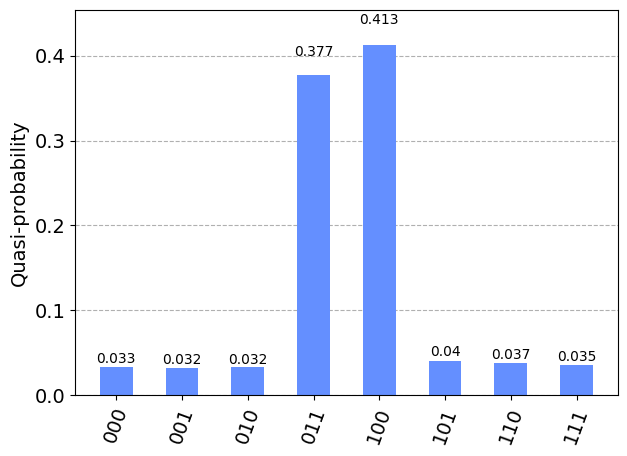